# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
from lib.summary import load_condensed_summary

In [3]:
places = [('CH', 'TI')]
ymax = {'CH' : {'TI': 100, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 300, 'KL': 2000, 'RH': 3500}}

## ROC

Loaded previously extracted data.
-0.010   TP 11.69 FP 2608.44  TN  0.00  FN  0.00
0.000   TP 11.69 FP 2608.00  TN  0.44  FN  0.00
0.010   TP 11.69 FP 2045.50  TN 562.94  FN  0.00
0.020   TP 11.44 FP 1737.44  TN 871.00  FN  0.25
0.030   TP 10.88 FP 1486.38  TN 1122.06  FN  0.81
0.040   TP 10.19 FP 1265.19  TN 1343.25  FN  1.50
0.050   TP  9.44 FP 1081.94  TN 1526.50  FN  2.25
0.060   TP  8.56 FP 910.56  TN 1697.88  FN  3.12
0.070   TP  8.25 FP 776.69  TN 1831.75  FN  3.44
0.080   TP  7.81 FP 662.69  TN 1945.75  FN  3.88
0.090   TP  7.00 FP 564.88  TN 2043.56  FN  4.69
0.100   TP  6.62 FP 477.31  TN 2131.12  FN  5.06
0.110   TP  6.12 FP 404.62  TN 2203.81  FN  5.56
0.120   TP  5.62 FP 349.31  TN 2259.12  FN  6.06
0.130   TP  4.88 FP 301.81  TN 2306.62  FN  6.81
0.140   TP  4.75 FP 263.56  TN 2344.88  FN  6.94
0.150   TP  4.62 FP 226.06  TN 2382.38  FN  7.06
0.160   TP  3.94 FP 193.56  TN 2414.88  FN  7.75
0.170   TP  3.69 FP 168.31  TN 2440.12  FN  8.00
0.180   TP  3.62 FP 147.62  TN 24

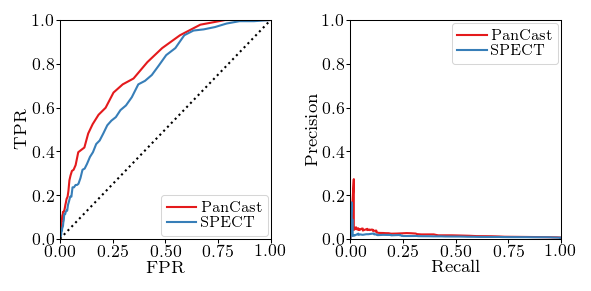

In [12]:
def plot_roc(country, area, p_adoption):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
         f'beacon-environment-{country}-{area}' : [
            Plot(label='tracing-stats', 
                path=(f'beacon-environment-{country}-{area}/'
                      f'beacon-environment-{country}-{area}-beacon=all-p_adoption={p_adoption}-x=8.0.pk')),
        ],
    }
    
    for plot_filename, plots in plots.items():
        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        
        #results = load_summary_list(paths)
        #summaries = get_properties(results, 'summary')
    
        # plots
        plotter = Plotter()

        plotter.plot_roc_curve(
            titles=labels,
            summaries=None,
            paths=paths,
            filename=plot_filename, 
            action='isolate',
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figsize=(4, 2), 
            figformat='neurips-double')
        
p_adoption = 1.0
        
for country, area in places:
    plot_roc(country, area, p_adoption)

In [ ]:
# Crop pdf margins
# !bash crop_pdfs.sh plots/beacon-environment-*.pdf


# Beacons


In [ ]:
def plot_beacon_proportion(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'beacons-proportion-{country}-{area}' : [
            Plot(label='P2P',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.25.pk')),
            
#             Plot(label='Beacon at top 5\% sites',
#                 path=(f'beacon-sparse-locations-{country}-{area}/'
#                       f'beacon-sparse-locations-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_mode=visit_freq-beacon_proportion=0.05.pk')),
#             Plot(label='Beacon at top 10\% sites',
#                 path=(f'beacon-sparse-locations-{country}-{area}/'
#                       f'beacon-sparse-locations-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_mode=visit_freq-beacon_proportion=0.1.pk')),
            Plot(label='Beacon at top 25\% sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_mode=visit_freq-beacon_proportion=0.25.pk')),
            Plot(label='Beacon at top 50\% sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_mode=visit_freq-beacon_proportion=0.5.pk')),
            Plot(label='Beacon at all sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_mode=visit_freq-beacon_proportion=1.0.pk')),
            
        
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

In [ ]:
plot_beacon_proportion(country, area, ymax)

In [ ]:
def plot_beacon_manual_tracing(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'beacons-manual-tracing-{country}-{area}' : [
            Plot(label='P2P, 10\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.1.pk')),
            Plot(label='P2P, 25\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.25.pk')),
            Plot(label='P2P, 50\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.5.pk')),
            Plot(label='P2P, 100\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=1.0.pk')),
                
            
            Plot(label='Beacon, 10\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=0.1-p_recall=1.0-beacon_proportion=1.0-p_willing_to_share=1.0.pk')),
            Plot(label='Beacon, 25\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=0.25-p_recall=1.0-beacon_proportion=1.0-p_willing_to_share=1.0.pk')),
            Plot(label='Beacon, 50\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_proportion=1.0-p_willing_to_share=1.0.pk')),
            Plot(label='Beacon, 100\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=1.0-p_recall=1.0-beacon_proportion=1.0-p_willing_to_share=1.0.pk')),    
        
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

In [ ]:
plot_beacon_manual_tracing(country, area, ymax)